# <center> Proposing a ML model based on LSQ answers </center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import os
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as logistic
from xgboost.sklearn import XGBClassifier as XGBC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from scipy.stats import ttest_ind_from_stats as ttest
from math import comb
import shap
SEED = 42

import warnings
warnings.filterwarnings('ignore')

C:\Users\mateu\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def combine_questions(X):
    head = [['q1q2','q1q3','q1q5','q1q6','q1q7','q1q8','q1q9','q1q10','q1q11','q1q12','q1q13'],
                   ['q2q3','q2q5','q2q6','q2q7','q2q8','q2q9','q2q10','q2q11','q2q12','q2q13'],
                          ['q3q5','q3q6','q3q7','q3q8','q3q9','q3q10','q3q11','q3q12','q3q13'],
                                 ['q5q6','q5q7','q5q8','q5q9','q5q10','q5q11','q5q12','q5q13'],
                                        ['q6q7','q6q8','q6q9','q6q10','q6q11','q6q12','q6q13'],
                                               ['q7q8','q7q9','q7q10','q7q11','q7q12','q7q13'],
                                                      ['q8q9','q8q10','q8q11','q8q12','q8q13'],
                                                             ['q9q10','q9q11','q9q12','q9q13'],
                                                                     ['q10q11','q10q12','q10q13'],
                                                                              ['q11q12','q11q13'],
                                                                                       ['q12q13']]

    cont1 = 0
    cont2 = 1

    for i in head:
        for j in range(0,len(i),1):
            pos = len(X.columns)
            X.insert(pos, 
                     i[j], 
                     X.iloc[:,cont1] * X.iloc[:,cont2] )
            cont2+=1
        cont1+=1
        cont2 = cont1+1
    return X

In [3]:
def phi_coefficient(X):
    association = []

    for column1 in X:
        for column2 in X: 
            assoc = matthews_corrcoef(X[column1],X[column2])
            association.append(assoc)

    association = np.array(association)
    association = association.reshape((len(X.columns),len(X.columns)))
    
    return association

In [4]:
def remove_high_association(X, assoc, threshold=0.75):
    res1 = assoc.columns.tolist()
    res2 = assoc.index.tolist()

    lig = []

    res1.pop(0)

    for i in res2:
        for j in res1:
            if (assoc.loc[i,j] >= threshold) & (assoc.loc[i,j] < 1):
                lig.append(j)
        if res1:
            res1.pop(0)

    columns = list(set(lig))
    X.drop(columns=columns, inplace=True)
    return X,columns

In [5]:
def print_gridsearch(gridsearch):
    print("\n")
    print("Best model: roc_auc = %f with %s" % (gridsearch.best_score_, gridsearch.best_params_))

In [6]:
def metrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = cm.ravel()
    sens = tp/(tp+fn)
    espe = tn/(fp+tn)
    prec = tp/(tp+fp)
    vpne = tn/(tn+fn)
    y_scores = clf.predict_proba(X_test)[::,1]
    fpr_, tpr_, _ = roc_curve(y_test,  y_scores)
    auc_ = roc_auc_score(y_test, y_pred)
    
    return {'cm':cm,
            'sens':sens,
            'espe':espe,
            'prec':prec,
            'vpne':vpne,
            'tpr':tpr_,
            'fpr':fpr_,
            'auc':auc_}

In [7]:
def shap_plots(shap_values, X_test, clf_name):
    
    plt.figure(figsize=(10,5))

    plt.subplot(2,2,1)
    shap.summary_plot(shap_values, X_test, 
                      feature_names=X_test.columns,
                      show=False,
                      plot_size=None)
    
    plt.suptitle(clf_name)

    plt.tight_layout()
    plt.show()

## 3. Importing dataset<a class="anchor" id="read"></a>

In [8]:
df = pd.read_csv('dataset.csv')

In [9]:
df.head()

,sex,age,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,target
0,M,78.0,0,0,0,NaN,0,1,0,0,0,0,0,0,0,NaN,Healthy
1,M,54.0,0,0,1,NaN,0,0,0,0,0,0,0,0,0,NaN,Healthy
2,M,50.0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,NaN,Healthy
3,F,43.0,1,1,0,NaN,0,1,0,0,0,0,0,0,0,NaN,Healthy
4,F,32.0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,NaN,Healthy


|  Variable |                          Description                                    |       Type        |
|:---------:|-------------------------------------------------------------------------|:-----------------:|
| sex       | Sex of the participant                                                  |        M/F        |
| age       | Age of the participant                                                  |        int        |
| q1        | Do you fell numbness in your hands and/or feet?                         |        0/1        |
| q2        | Tingling (pricking)?                                                    |        0/1        |
| q3        | Anesthetized areas in the skin?                                         |        0/1        |
| q4        | Muscle cramps?                                                          |        0/1        |
| q5        | Stinging sensation?                                                     |        0/1        |
| q6        | Spots on the skin? (do not consider those from birth)                   |        0/1        |
| q7        | Pain in the nerves?                                                     |        0/1        |
| q8        | Nodules on the skin?                                                    |        0/1        |
| q9        | Swelling of hands and feet?                                             |        0/1        |
| q10       | Swelling of face?                                                       |        0/1        |
| q11       | Weakness in hands? Hard to button shirt? Wear glasses? Write? Hold pans?|        0/1        |
| q12       | Weakness in feet? Difficulty wearing sandals, slippers?                 |        0/1        |
| q13       | Loss of eyelashes? Loss of eyebrows?                                    |        0/1        |
| q14       | Does anyone in your family have or have had leprosy?                    |        0/1        |
| target    | Describes if the individual either is healthy or a new case detection   | healthy/new_case  |

## 4. Pre-processing

### _4.1. Separating X and y_ <a class="anchor" id="separate"></a>

In [10]:
X = df.loc[:, ('q1','q2','q3','q4','q5','q6','q7','q8','q9','q10','q11','q12','q13','q14')]
y = df['target'].replace({'Healthy':0,
                          'New Case':1}).astype('bool')

### _4.2. Missing Data_ <a class="anchor" id="missing"></a>

Dropping columns q14 and q4

In [11]:
X.drop(columns=['q4','q14'], inplace=True)

### _4.3. Splitting into training and test sets_ <a class="anchor" id="split"></a>

We stratified the dataset only based on the outcomes ```Healthy``` or ```New Case```

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED, 
                                                    stratify=y)

### _4.4. Data augmentation combining questions_ <a class="anchor" id="combine">

In [13]:
X_train = combine_questions(X_train)
X_test  = combine_questions(X_test)

### _4.5. $\phi$ coefficient_

In [14]:
association = phi_coefficient(X_train)

Eliminating $\phi \geq 0.75$

In [15]:
association = pd.DataFrame(association,columns=X_train.columns, index=X_train.columns)
X_train,colunas = remove_high_association(X_train, association)
print(f'From {X_test.shape[1]} columns to {X_train.shape[1]} columns.\n')
print(f'Removed variables: {[list(x) for x in zip(colunas)]}')
X_test.drop(columns=colunas, inplace=True)

From 78 columns to 54 columns.

Removed variables: [['q2q5'], ['q1q11'], ['q1q2'], ['q2q9'], ['q12q13'], ['q7q13'], ['q7q12'], ['q2q11'], ['q5q7'], ['q2q6'], ['q7q11'], ['q7q10'], ['q1q12'], ['q2q7'], ['q1q3'], ['q2q3'], ['q2q12'], ['q9q10'], ['q2q13'], ['q9q13'], ['q1q5'], ['q7q9'], ['q3q7'], ['q2q10']]


### _4.6. Boruta_ <a class="anchor" id="boruta"></a>

First we applied SMOTE. We create new variables ```X_smo``` and ```y_smo``` specifically for this step. Both will not be used in training stage.

In [16]:
sm = SMOTE(random_state=SEED)
X_smo, y_smo = sm.fit_resample(X_train,y_train)

Creating R environment

In [17]:
os.environ['R_HOME'] = 'C:\\Users\\mateu\\anaconda3\\Lib\\R'
os.environ['R_USER'] = 'C:\\Users\\mateu\\anaconda3\\Lib\\site-packages\\rpy2' 

%load_ext rpy2.ipython

Applying Boruta in R

In [18]:
%%R -i X_smo -i y_smo -i SEED

library(Boruta)

set.seed(SEED)
boruta <- Boruta(X_smo,y_smo,pvalue=0.05)

write.csv(attStats(boruta),'borutaAttStats.csv')

In [19]:
boruta_r_attStats = pd.read_csv('borutaAttStats.csv', index_col=0)
boruta_r_attStats = boruta_r_attStats.sort_values(by='meanImp')

columns_to_drop = []
for index, row in boruta_r_attStats.iterrows():
    if (boruta_r_attStats.decision[index] == 'Rejected') | (boruta_r_attStats.decision[index] == 'Tentative'):
        columns_to_drop.append(index)

print('Columns dropped: ', columns_to_drop)

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

Columns dropped:  ['q8q13', 'q8q12', 'q10q13', 'q3q13', 'q3q8', 'q10q12', 'q3q12', 'q8q10', 'q5q12', 'q3q10', 'q11q13', 'q8q11', 'q5q13', 'q5q10', 'q6q13', 'q10q11']


In [20]:
X_train.shape

(1473, 38)

## 5. Classifiers <a class="anchor" id="classifiers"></a>

In [21]:
# CLASSIFIERS
clf = {
        'SVM': SVC(random_state= SEED, 
                   probability=  True),
    
        'LR' : logistic(random_state=SEED, 
                        max_iter=200,
                        solver='saga'),
    
        'RF' : RF(random_state=SEED),
    
        'XGB': XGBC(random_state= SEED, 
                    probability=  True,
                    objective=    'binary:logistic',
                    eval_metric=  'auc',
                    verbosity=    0)
}

# CROSS-VALIDATION METHOD
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=SEED)

### _5.1. Classifiers without hyperparameters optimization_ <a class="anchor" id="no_optimization"></a>

In [22]:
for key, value in clf.items():
    pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=SEED)],
                                    ['classifier', value]])
    scores = cross_val_score(pipeline, X_train, y_train, cv=rskf, scoring='roc_auc')
    print(key+" ---> roc_auc = %.3f (%.3f)" % (scores.mean(), scores.std()))

SVM ---> roc_auc = 0.700 (0.064)
LR ---> roc_auc = 0.701 (0.060)
RF ---> roc_auc = 0.609 (0.073)
XGB ---> roc_auc = 0.604 (0.072)


### _5.2. Classifiers with hyperparameter optimization_ <a class="anchor" id="optimization"></a>

#### 5.2.1. Support Vectors Machine (SVM) <a class="anchor" id="svm"></a>

In [23]:
svm_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=SEED)],
                                    ['classifier', clf['SVM']]])

grid_parametros = {
    
        'classifier__C':       np.logspace(-4, 4, 10),
        'classifier__kernel':  ['linear','sigmoid','poly','rbf']
    
    }

grid_cv_svm = GridSearchCV(svm_pipeline,
                           grid_parametros,
                           scoring='roc_auc',
                           cv=rskf,
                           refit=True,
                           n_jobs=-1)

_ = grid_cv_svm.fit(X_train,y_train)

print_gridsearch(grid_cv_svm)



Best model: roc_auc = 0.754249 with {'classifier__C': 0.046415888336127774, 'classifier__kernel': 'rbf'}


#### 5.2.2. Logistic Regression (LR) <a class="anchor" id="lr"></a>

In [24]:
lr_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=SEED)],
                                   ['classifier', clf['LR']]])

grid_parametros = {
    
        'classifier__C':      np.logspace(-4, 4, 50),
        'classifier__penalty': ['l1','l2','none']
    
    }

grid_cv_lr = GridSearchCV(lr_pipeline,
                          grid_parametros,
                          scoring='roc_auc',
                          cv=rskf,
                          refit=True,
                          n_jobs=-1)

_ = grid_cv_lr.fit(X_train,y_train)

print_gridsearch(grid_cv_lr) 



Best model: roc_auc = 0.753329 with {'classifier__C': 0.0020235896477251557, 'classifier__penalty': 'l2'}


#### 5.2.3. Random Forest (RF) <a class="anchor" id="rf"></a>

In [25]:
rf_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=SEED)],
                                   ['classifier', clf['RF']]])

##### _5.2.3.1. Optimizing n-estimators and max-depth_ <a class="anchor" id="rfh1"></a>

In [26]:
grid_parametros = {
    
    'classifier__n_estimators':     range(50,700,50),
    'classifier__max_depth':        range(5,51,5)
    
    }

grid_cv_rf = GridSearchCV(rf_pipeline,
                          grid_parametros,
                          scoring='roc_auc',
                          cv=rskf,
                          refit=True,
                          n_jobs=-1)

_ = grid_cv_rf.fit(X_train,y_train)

print_gridsearch(grid_cv_rf)



Best model: roc_auc = 0.714166 with {'classifier__max_depth': 5, 'classifier__n_estimators': 450}


##### _5.2.3.2. Optimizing min-samples-split and max-features_ <a class="anchor" id="rfh2"></a>

In [27]:
grid_parametros = {
    
    'classifier__n_estimators':     [450],
    'classifier__max_depth':        [5],
    'classifier__min_samples_split': range(10,101,10),
    'classifier__max_features':      range(1,13,1)
    
    }

grid_cv_rf = GridSearchCV(rf_pipeline,
                          grid_parametros,
                          scoring='roc_auc',
                          cv=rskf,
                          refit=True,
                          n_jobs=-1)

_ = grid_cv_rf.fit(X_train,y_train)

print_gridsearch(grid_cv_rf) 



Best model: roc_auc = 0.731507 with {'classifier__max_depth': 5, 'classifier__max_features': 6, 'classifier__min_samples_split': 100, 'classifier__n_estimators': 450}


##### _5.2.3.3. Optimizing min-samples-leaf and max-samples_ <a class="anchor" id="rfh3">

In [28]:
grid_parametros = {
    
    'classifier__n_estimators':      [450],
    'classifier__max_depth':         [5],
    'classifier__min_samples_split': [100],
    'classifier__max_features':      [6],
    'classifier__max_samples':      [i/10 for i in range(2,10)],
    'classifier__min_samples_leaf': range(10,101,10)
    
    }

grid_cv_rf = GridSearchCV(rf_pipeline,
                          grid_parametros,
                          scoring='roc_auc',
                          cv=rskf,
                          refit=True,
                          n_jobs=-1)

_ = grid_cv_rf.fit(X_train,y_train)

print_gridsearch(grid_cv_rf)  



Best model: roc_auc = 0.756002 with {'classifier__max_depth': 5, 'classifier__max_features': 6, 'classifier__max_samples': 0.3, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 100, 'classifier__n_estimators': 450}


##### _5.2.3.4. Optimizing max-terminal-nodes_ <a class="anchor" id="rfh4">

In [29]:
grid_parametros = {
    
    'classifier__n_estimators':       [450],
    'classifier__max_depth':          [5],
    'classifier__min_samples_split':  [100],
    'classifier__max_features':       [6],
    'classifier__min_samples_leaf':   [10],
    'classifier__max_samples':        [0.3],
    'classifier__max_leaf_nodes': range(3,31,3)
    
    }

grid_cv_rf = GridSearchCV(rf_pipeline,
                          grid_parametros,
                          scoring='roc_auc',
                          cv=rskf,
                          refit=True,
                          n_jobs=-1)

_ = grid_cv_rf.fit(X_train,y_train)


print("Best model: roc_auc = %f with %s" % (grid_cv_rf.best_score_, grid_cv_rf.best_params_))

Best model: roc_auc = 0.755310 with {'classifier__max_depth': 5, 'classifier__max_features': 6, 'classifier__max_leaf_nodes': 9, 'classifier__max_samples': 0.3, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 100, 'classifier__n_estimators': 450}


#### 5.2.4. Extreme Gradient Boosting (XGBoost/XGB) <a class="anchor" id="xgb"></a>

In [30]:
xgb_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=SEED)],
                                    ['classifier', clf['XGB']]])

##### 6.2.4.1. Optimizing eta and n-estimators <a class="anchor" id="xgbh1"></a>

In [31]:
grid_parametros = {
    
    "classifier__subsample":        [0.8], 
    "classifier__colsample_bytree": [0.8],
    'classifier__learning_rate':    [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'classifier__n_estimators':     range(50,700,50)
    
    }

grid_cv_xgb1 = GridSearchCV(xgb_pipeline,
                            grid_parametros,
                            scoring='roc_auc',
                            cv=rskf,
                            refit=True,
                            n_jobs=-1)

_ = grid_cv_xgb1.fit(X_train,y_train)

print_gridsearch(grid_cv_xgb1)    



Best model: roc_auc = 0.709828 with {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


##### 5.2.4.2. Optimizing max-depth and min-child-weight <a class="anchor" id="xgbh2"></a>

In [32]:
grid_parametros = {
    
    'classifier__subsample':        [0.8], 
    'classifier__colsample_bytree': [0.8],
    'classifier__learning_rate':    [0.0001],
    'classifier__n_estimators':     [100],
    'classifier__max_depth':        range(2,10,2),
    'classifier__min_child_weight':  range(1,6,2)
    
    }

grid_cv_xgb1 = GridSearchCV(xgb_pipeline, 
                            grid_parametros,
                            scoring='roc_auc',
                            cv=rskf,
                            refit=True,
                            n_jobs=-1)

_ = grid_cv_xgb1.fit(X_train,y_train)

print_gridsearch(grid_cv_xgb1)   



Best model: roc_auc = 0.742196 with {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.0001, 'classifier__max_depth': 6, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


##### 5.2.4.3. Optimizing subsample and colsample-bytree <a class="anchor" id="xgbh3"></a>

In [35]:
grid_parametros = {
    
    'classifier__learning_rate':    [0.0001],
    'classifier__n_estimators':     [100],
    'classifier__max_depth':        [6],
    'classifier__min_child_weight': [5],
    'classifier__subsample':        [i/10 for i in range(4,10)],
    'classifier__colsample_bytree': [i/10 for i in range(4,10)]
    
    }

grid_cv_xgb1 = GridSearchCV(xgb_pipeline,
                            grid_parametros,
                            scoring='roc_auc',
                            cv=rskf,
                            refit=True,
                            n_jobs=-1)

_ = grid_cv_xgb1.fit(X_train,y_train)

print_gridsearch(grid_cv_xgb1)   



Best model: roc_auc = 0.757500 with {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.0001, 'classifier__max_depth': 6, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5}


##### 5.2.4.4. Optimizing lambda and gamma <a class="anchor" id="xgbh4"></a>

In [36]:
grid_parametros = {
    
    'classifier__learning_rate':    [0.0001],
    'classifier__n_estimators':     [100],
    'classifier__max_depth':        [6],
    'classifier__min_child_weight': [5],
    'classifier__subsample':        [0.5],
    'classifier__colsample_bytree': [0.5],
    'classifier__gamma':            [i/10 for i in range(1,11)],
    'classifier__lambda':           [i/2  for i in range(1,11)]
    
    }

grid_cv_xgb1 = GridSearchCV(xgb_pipeline,
                            grid_parametros,
                            scoring='roc_auc',
                            cv=rskf,
                            refit=True,
                            n_jobs=-1)

_ = grid_cv_xgb1.fit(X_train,y_train)

print_gridsearch(grid_cv_xgb1)



Best model: roc_auc = 0.758034 with {'classifier__colsample_bytree': 0.5, 'classifier__gamma': 0.2, 'classifier__lambda': 1.0, 'classifier__learning_rate': 0.0001, 'classifier__max_depth': 6, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5}


##### 5.2.4.5. Optimizing alpha <a class="anchor" id="xgbh5"></a>

In [37]:
grid_parametros = {
    
    'classifier__learning_rate':    [0.0001],
    'classifier__n_estimators':     [100],
    'classifier__max_depth':        [6],
    'classifier__min_child_weight': [5],
    'classifier__subsample':        [0.5],
    'classifier__colsample_bytree': [0.5],
    'classifier__gamma':            [0.2],
    'classifier__lambda':           [1.0],
    'classifier__alpha':            [i/100  for i in range(1,11)]
    
    }

grid_cv_xgb1 = GridSearchCV(xgb_pipeline,
                            grid_parametros,
                            scoring='roc_auc',
                            cv=rskf,
                            refit=True,
                            n_jobs=-1)

_ = grid_cv_xgb1.fit(X_train,y_train)

print("Best model: roc_auc = %f with %s" % (grid_cv_xgb1.best_score_, grid_cv_xgb1.best_params_))

Best model: roc_auc = 0.758315 with {'classifier__alpha': 0.02, 'classifier__colsample_bytree': 0.5, 'classifier__gamma': 0.2, 'classifier__lambda': 1.0, 'classifier__learning_rate': 0.0001, 'classifier__max_depth': 6, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5}


#### 5.2.5. Evaluating classifications performance <a class="anchor" id="evaluation"></a>

In [38]:
clf_final = {    
    'SVM': grid_cv_svm,
    'LR':  grid_cv_lr,
    'RF':  grid_cv_rf,
    'XGB': grid_cv_xgb1
}

color = {
    'SVM': 'red', 
    'LR':  'blue', 
    'RF':  'green', 
    'XGB': 'goldenrod'
}

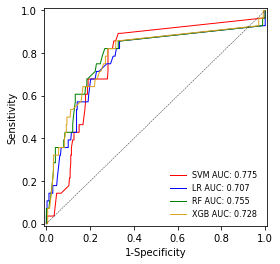

In [39]:
sens = []
espe = []
prec = []
vpne = []
auce = []

plt.figure(figsize=(4, 4))

for key,value in clf_final.items():
    
    #OBTENDO AS MÉTRICAS
    metricas_salvas = metrics(value,X_test,y_test)
    
    #METRICAS LIMIARES COM 3 CASAS DECIMAIS
    sens.append(round(metricas_salvas['sens'],3))
    espe.append(round(metricas_salvas['espe'],3))
    prec.append(round(metricas_salvas['prec'],3))
    vpne.append(round(metricas_salvas['vpne'],3))
    auce.append(round(metricas_salvas['auc'],3))
    
    #PLOT DAS CURVAS ROC
    plt.plot(metricas_salvas['fpr'], metricas_salvas['tpr'],
             label = (key+f" AUC: {round(metricas_salvas['auc'],3)} "),
             color=color[key],
             alpha = 1.0,
             linewidth = 1)

plt.plot([0, 1], [0, 1], 
         linestyle = '--', 
         lw = .5, 
         color = 'black', 
         alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.legend(loc='lower right', fontsize=8, frameon=False)
plt.show()

In [40]:
metricas_limiares = pd.DataFrame(
    {
        'Sensitivity':              sens, 
        'Specificity':              espe, 
        'Precision':                prec, 
        'Negative predicted value': vpne,
        'AUC':                      auce
    }, index=clf_final.keys())
metricas_limiares

,Sensitivity,Specificity,Precision,Negative predicted value,AUC
SVM,0.857,0.692,0.186,0.983,0.775
LR,0.607,0.806,0.205,0.962,0.707
RF,0.750,0.760,0.204,0.974,0.755
XGB,0.679,0.777,0.200,0.967,0.728


#### 5.2.6. Variable importance using Shapley values <a class="anchor" id="shap"></a>

In [41]:
# INICIALIZANDO SHAP

shap.initjs()

SVM:

Permutation explainer: 370it [10:48,  1.77s/it]                         


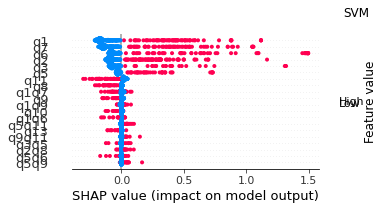

In [42]:
exp_svm = shap.Explainer(grid_cv_svm.best_estimator_.decision_function, 
                         X_test,
                         feature_names=X_test.columns)
shap_values_svm = exp_svm(X_test)

shap_plots(shap_values_svm, X_test,'SVM')

Logistic Regression

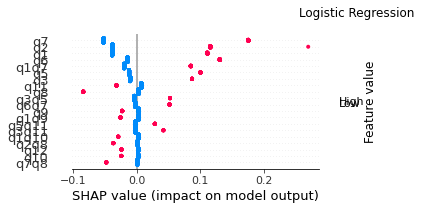

In [43]:
exp_lr = shap.Explainer(grid_cv_lr.best_estimator_.decision_function, 
                        X_test,
                        feature_names=X_test.columns)
shap_values_lr = exp_lr(X_test)

shap_plots(shap_values_lr, X_test,'Logistic Regression')

Random Forest:

Permutation explainer: 370it [02:40,  2.16it/s]                         


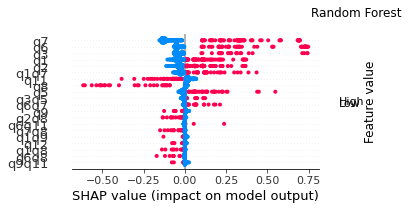

In [44]:
exp_rf = shap.Explainer(grid_cv_rf.best_estimator_[1].predict, 
                        X_test,
                        feature_names=X_test.columns)
shap_values_rf = exp_rf(X_test)

shap_plots(shap_values_rf, X_test,'Random Forest')

XGBoost:

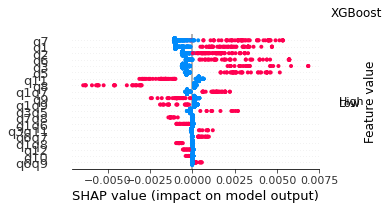

In [45]:
exp_xgb = shap.Explainer(grid_cv_xgb1.best_estimator_[1], 
                     X_test,
                     feature_names=X_test.columns)
shap_values_xgb = exp_xgb(X_test)

shap_plots(shap_values_xgb, X_test,'XGBoost')